<a href="https://colab.research.google.com/github/scorepia/Project_mornortor/blob/main/GAN_Signature_Handwritten.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Handwritten Handwritten Generation - ScrabbleGAN




1.   Data Collection - IAM Database
2.   Set Config and Parameter - ScrabbleGAN
3.   Train Model
4.   Generate Images


In [1]:
#GPU check
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Dec 25 11:18:26 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    52W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Clone model 

In [2]:
# download project
!git clone -b dev https://github.com/Nikolai10/scrabble-gan.git

Cloning into 'scrabble-gan'...
remote: Enumerating objects: 69, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 69 (delta 26), reused 16 (delta 16), pack-reused 31
Unpacking objects: 100% (69/69), done.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Data Preparation 

In [5]:
#download IAM-databases
!mkdir -p /content/scrabble-gan/res/data/iamDB
!unzip /content/drive/MyDrive/data.zip -d /content/scrabble-gan/res/

เอาต์พุตของการสตรีมมีการตัดเหลือเพียง 5000 บรรทัดสุดท้าย
  inflating: /content/scrabble-gan/res/data/iamDB/words/h07/h07-071a/h07-071a-07-07.png  
  inflating: /content/scrabble-gan/res/__MACOSX/data/iamDB/words/h07/h07-071a/._h07-071a-07-07.png  
  inflating: /content/scrabble-gan/res/data/iamDB/words/h07/h07-071a/h07-071a-05-02.png  
  inflating: /content/scrabble-gan/res/__MACOSX/data/iamDB/words/h07/h07-071a/._h07-071a-05-02.png  
  inflating: /content/scrabble-gan/res/data/iamDB/words/h07/h07-071a/h07-071a-05-03.png  
  inflating: /content/scrabble-gan/res/__MACOSX/data/iamDB/words/h07/h07-071a/._h07-071a-05-03.png  
  inflating: /content/scrabble-gan/res/data/iamDB/words/h07/h07-071a/h07-071a-07-06.png  
  inflating: /content/scrabble-gan/res/__MACOSX/data/iamDB/words/h07/h07-071a/._h07-071a-07-06.png  
  inflating: /content/scrabble-gan/res/data/iamDB/words/h07/h07-071a/h07-071a-09-03.png  
  inflating: /content/scrabble-gan/res/__MACOSX/data/iamDB/words/h07/h07-071a/._h07-071a-

## Import Libs

In [7]:
!pip install git+https://github.com/tensorflow/docs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-6ounchtk
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-6ounchtk
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0.dev0-py3-none-any.whl size=184468 sha256=17a34f0b43ada42c5908994fe3546294c74bfe04da7d8a6024c3d6b082a8949a
  Stored in directory: /tmp/pip-ephem-wheel-cache-pj9y2e5z/wheels/3b/ee/a2/ab4d36a9a4af495bcb936f3e849d4b497b65fa40548a68d6c3
Successfully built tensorflow-docs


In [8]:
import sys
sys.path.extend(['/content/scrabble-gan'])

import os
import random

import gin
import numpy as np
import tensorflow as tf
import tensorflow_docs.vis.embed as embed
import matplotlib.pyplot as plt

from src.bigacgan.arch_ops import spectral_norm
from src.bigacgan.data_utils import load_prepare_data, train, make_gif, load_random_word_list
from src.bigacgan.net_architecture import make_generator, make_discriminator, make_recognizer, make_gan
from src.bigacgan.net_loss import hinge, not_saturating

gin.external_configurable(hinge)
gin.external_configurable(not_saturating)
gin.external_configurable(spectral_norm)

from src.dinterface.dinterface import init_reading

## Setting Config Params

    ตั้งค่า Parameter จาก Configs file

In [9]:
@gin.configurable
def setup_optimizer(g_lr, d_lr, r_lr, beta_1, beta_2, loss_fn, disc_iters):
    generator_optimizer = tf.keras.optimizers.Adam(learning_rate=g_lr, beta_1=beta_1, beta_2=beta_2)
    discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=d_lr, beta_1=beta_1, beta_2=beta_2)
    recognizer_optimizer = tf.keras.optimizers.Adam(learning_rate=r_lr, beta_1=beta_1, beta_2=beta_2)
    return generator_optimizer, discriminator_optimizer, recognizer_optimizer, loss_fn, disc_iters


@gin.configurable('shared_specs')
def get_shared_specs(epochs, batch_size, latent_dim, embed_y, num_gen, kernel_reg, g_bw_attention, d_bw_attention):
    return epochs, batch_size, latent_dim, embed_y, num_gen, kernel_reg, g_bw_attention, d_bw_attention


@gin.configurable('io')
def setup_io(base_path, checkpoint_dir, gen_imgs_dir, model_dir, raw_dir, read_dir, input_dim, buf_size, n_classes,
             seq_len, char_vec, bucket_size):
    gen_path = base_path + gen_imgs_dir
    ckpt_path = base_path + checkpoint_dir
    m_path = base_path + model_dir
    raw_dir = base_path + raw_dir
    read_dir = base_path + read_dir
    return input_dim, buf_size, n_classes, seq_len, bucket_size, ckpt_path, gen_path, m_path, raw_dir, read_dir, char_vec

In [10]:
!pwd

/content


In [11]:
# init params
gin.parse_config_file('/content/scrabble-gan/src/scrabble_gan.gin')
epochs, batch_size, latent_dim, embed_y, num_gen, kernel_reg, g_bw_attention, d_bw_attention = get_shared_specs()
in_dim, buf_size, n_classes, seq_len, bucket_size, ckpt_path, gen_path, m_path, raw_dir, read_dir, char_vec = setup_io()

## Load and Preprocess Dataset

In [12]:
# convert IAM Handwriting dataset (words) to GAN format
if not os.path.exists(read_dir):
  print('converting iamDB-Dataset to GAN format...')
  init_reading(raw_dir, read_dir, in_dim, bucket_size)

# load random words into memory (used for word generation by G)
random_words = load_random_word_list(read_dir, bucket_size, char_vec)

# load and preprocess dataset (python generator)
train_dataset = load_prepare_data(in_dim, batch_size, read_dir, char_vec, bucket_size)

## Build Composite Model

In [13]:
# init generator, discriminator and recognizer
generator = make_generator(latent_dim, in_dim, embed_y, gen_path, kernel_reg, g_bw_attention, n_classes)
discriminator = make_discriminator(gen_path, in_dim, kernel_reg, d_bw_attention)
recognizer = make_recognizer(in_dim, seq_len, n_classes + 1, gen_path)

# build composite model (update G through composite model)
gan = make_gan(generator, discriminator, recognizer, gen_path)

# init optimizer for both generator, discriminator and recognizer
generator_optimizer, discriminator_optimizer, recognizer_optimizer, loss_fn, disc_iters = setup_optimizer()

input shape
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 SpatialEmbedding (SpatialEmbed  (None, None, 32, 81  13631488   ['input_2[0][0]']                
 ding)                          92)                                                               
                                                                                                  
 tf.split (TFOpLambda)          [(None, 32),         0           ['input_1[0][0]']

## Define Optimizers + Checkpoint-Saver


In [14]:
# purpose: save and restore models
checkpoint_prefix = os.path.join(ckpt_path, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                     discriminator_optimizer=discriminator_optimizer,
                                     recognizer_optimizer=recognizer_optimizer,
                                     generator=generator,
                                     discriminator=discriminator,
                                     recognizer=recognizer)


## Start Training

In [15]:
# reuse this seed + labels overtime to visualize progress in the animated GIF
seed = tf.random.normal([num_gen, latent_dim])
random_bucket_idx = random.randint(4, bucket_size - 1)
labels = np.array([random.choice(random_words[random_bucket_idx]) for _ in range(num_gen)], np.int32)

เอาต์พุตของการสตรีมมีการตัดเหลือเพียง 5000 บรรทัดสุดท้าย
>1, 26/2512, d=1.333, d_real=0.569, d_fake=0.765, g_trad=0.627, r_loss_fake=8.052, g_loss=8.679, r=7.930
>1, 27/2512, d=1.250, d_real=0.315, d_fake=0.935, g_trad=0.509, r_loss_fake=38.607, g_loss=39.116, r=35.000
>1, 28/2512, d=1.258, d_real=0.384, d_fake=0.873, g_trad=0.545, r_loss_fake=7.226, g_loss=7.771, r=21.934
>1, 29/2512, d=1.446, d_real=0.134, d_fake=1.312, g_trad=0.356, r_loss_fake=37.717, g_loss=38.073, r=10.283
>1, 30/2512, d=1.269, d_real=0.539, d_fake=0.729, g_trad=0.668, r_loss_fake=25.078, g_loss=25.745, r=33.732
>1, 31/2512, d=1.208, d_real=0.308, d_fake=0.900, g_trad=0.548, r_loss_fake=50.359, g_loss=50.907, r=15.839
>1, 32/2512, d=1.280, d_real=0.321, d_fake=0.958, g_trad=0.494, r_loss_fake=31.046, g_loss=31.540, r=10.502
>1, 33/2512, d=1.247, d_real=0.396, d_fake=0.851, g_trad=0.561, r_loss_fake=26.333, g_loss=26.894, r=9.608
>1, 34/2512, d=1.210, d_real=0.340, d_fake=0.869, g_trad=0.556, r_loss_fake=36.561, g

/content/scrabble-gan/src/bigacgan/data_utils.py:274: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(4, 4, i + 1)


เอาต์พุตของการสตรีมมีการตัดเหลือเพียง 5000 บรรทัดสุดท้าย
>14, 26/2512, d=0.003, d_real=0.003, d_fake=0.000, g_trad=14.264, r_loss_fake=1.300, g_loss=15.563, r=0.218
>14, 27/2512, d=0.000, d_real=0.000, d_fake=0.000, g_trad=13.548, r_loss_fake=1.953, g_loss=15.501, r=0.094
>14, 28/2512, d=0.000, d_real=0.000, d_fake=0.000, g_trad=14.612, r_loss_fake=5.769, g_loss=20.380, r=0.092
>14, 29/2512, d=0.000, d_real=0.000, d_fake=0.000, g_trad=13.067, r_loss_fake=2.436, g_loss=15.503, r=0.293
>14, 30/2512, d=0.018, d_real=0.018, d_fake=0.000, g_trad=13.789, r_loss_fake=0.764, g_loss=14.552, r=0.202
>14, 31/2512, d=0.000, d_real=0.000, d_fake=0.000, g_trad=10.986, r_loss_fake=1.785, g_loss=12.772, r=0.501
>14, 32/2512, d=0.000, d_real=0.000, d_fake=0.000, g_trad=13.977, r_loss_fake=2.587, g_loss=16.564, r=0.526
>14, 33/2512, d=0.000, d_real=0.000, d_fake=0.000, g_trad=12.271, r_loss_fake=2.102, g_loss=14.374, r=0.737
>14, 34/2512, d=0.000, d_real=0.000, d_fake=0.000, g_trad=14.279, r_loss_fake=2

Time for epoch 15 is 780.7307770252228 sec


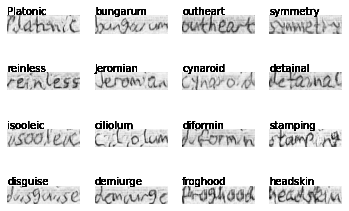

In [16]:
# start training
train(train_dataset, generator, discriminator, recognizer, gan, checkpoint, checkpoint_prefix, generator_optimizer,
          discriminator_optimizer, recognizer_optimizer, [seed, labels], buf_size, batch_size, epochs, m_path,
          latent_dim, gen_path, loss_fn, disc_iters, random_words, bucket_size, char_vec)


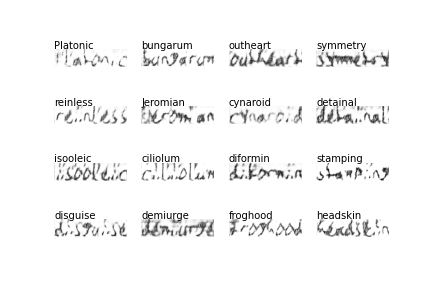

In [17]:
# use imageio to create an animated gif using the images saved during training.
make_gif(gen_path)
embed.embed_file(gen_path + 'biggan.gif')

## Run Inference On Your Data

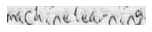

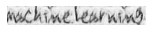

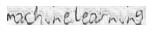

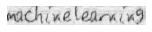

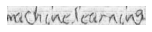

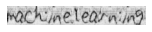

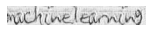

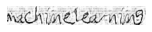

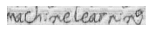

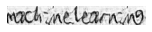

In [18]:
path_to_saved_model = '/content/scrabble-gan/res/out/big_ac_gan/model/generator_' + str(epochs)

# number of samples to generate
n_samples = 10
# your sample string
sample_string = 'machinelearning'

# load trained model
imported_model = tf.saved_model.load(path_to_saved_model)

# inference loop
for idx in range(1):
  fake_labels = []
  words = [sample_string] * 10
  noise = tf.random.normal([n_samples, latent_dim])
  
  # encode words
  for word in words:
    fake_labels.append([char_vec.index(char) for char in word])
  fake_labels = np.array(fake_labels, np.int32)

  # run inference process
  predictions = imported_model([noise, fake_labels], training=False)
  # transform values into range [0, 1]
  predictions = (predictions + 1) / 2.0

  # plot results
  for i in range(predictions.shape[0]):
    plt.subplot(10, 1, i + 1)
    plt.imshow(predictions[i, :, :, 0], cmap='gray')
    # plt.text(0, -1, "".join([char_vec[label] for label in fake_labels[i]]))
    plt.axis('off')
    plt.show()

In [21]:
!zip -r /content/scrabble-gan/res/out/big_ac_gan/model/generator_15.zip /content/scrabble-gan/res/out/big_ac_gan/model/generator_15

  adding: content/scrabble-gan/res/out/big_ac_gan/model/generator_15/ (stored 0%)
  adding: content/scrabble-gan/res/out/big_ac_gan/model/generator_15/saved_model.pb (deflated 91%)
  adding: content/scrabble-gan/res/out/big_ac_gan/model/generator_15/variables/ (stored 0%)
  adding: content/scrabble-gan/res/out/big_ac_gan/model/generator_15/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: content/scrabble-gan/res/out/big_ac_gan/model/generator_15/variables/variables.index (deflated 69%)
  adding: content/scrabble-gan/res/out/big_ac_gan/model/generator_15/assets/ (stored 0%)
  adding: content/scrabble-gan/res/out/big_ac_gan/model/generator_15/keras_metadata.pb (deflated 93%)
